# RF on ECFP4 fingerprints

**Goal.** Train a Random Forest for cancer vs. non-cancer on binary ECFP4 fingerprints and compare operating points (default 0.50, tuned-F1, screening 0.20, recall-targeted).

- **Data:** `ecfp_final.csv` with `fp_0 … fp_2047` (2048 bits) and `Label` (0/1).
- **Model:** `RandomForestClassifier` wrapped in a pipeline with `SelectFromModel(LogisticRegression)` for embedded feature selection.
- **Why FS before RF?** LR weights surface informative bits and prune noise; fewer features reduce RF variance and speed up CV.
- **Class imbalance:** Use `class_weight="balanced_subsample"` in RF (better than `"balanced"` for tree bagging); score with **Average Precision (PR-AUC)**.

## Setup

- **Libraries:** `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`.
- **Drive (Colab):** mount `/content/drive` to read/write CSVs.


In [1]:
# Imports (core + modeling + metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_curve, roc_curve
)

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split

from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
import matplotlib.pyplot as plt

In [2]:
# Colab Drive mount (data I/O)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Load data

- Read `ecfp_final.csv`.
- Features: 2048-bit ECFP columns.
- Target: `Label` cast to integer.


In [3]:
# Load the CSV with ECFP fingerprints + Label
df = pd.read_csv('/content/drive/My Drive/ecfp_final.csv')

# Assuming your CSV has columns like fp_0, fp_1, ..., fp_2047
X = df[[f'fp_{i}' for i in range(2048)]].values

# Labels
y = df['Label'].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape, " | Positives:", y.sum())

X shape: (12306, 2048)
y shape: (12306,)  | Positives: 225


## Data split

- **Validation**: hold out 20% to tune thresholds and report early results.  
- **Train/Test**: split the remaining 80% into 70% train and 10% test.  
- All splits are **stratified** and use `random_state=42`.

In [4]:
# Hold out 20% for validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split remaining 80% into train and test
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Validation:", X_val.shape)


Train: (8613, 2048)
Test: (1231, 2048)
Validation: (2462, 2048)


## Model pipeline

- **Feature selection:** `SelectFromModel(LogisticRegression)` with `threshold="median"`  
  keeps roughly the top half of bits by absolute coefficient (tuned in search).
- **Classifier:** `RandomForestClassifier(class_weight="balanced_subsample", random_state=42, bootstrap=True)`.
- **Search space (RandomizedSearchCV):**
  - `select__threshold ∈ {"median", "mean"}`
  - `rf__n_estimators ∈ randint(150, 400)`
  - `rf__max_depth ∈ {None} ∪ {8, 12, 16, …, 36}`
  - `rf__max_features ∈ {"sqrt", "log2", 0.5, 0.3}`
  - `rf__min_samples_split ∈ randint(2, 11)`
  - `rf__min_samples_leaf ∈ randint(1, 5)`
  - `rf__max_samples ∈ uniform(0.6, 0.4)`  <!-- subsampling per tree -->
- **CV:** `StratifiedKFold(n_splits=3, shuffle=True, random_state=42)`.
- **Scoring:** `average_precision` (threshold-free, imbalance-aware).
- **Report:** best hyperparameters and number of selected bits after refit.

In [5]:
# RF with FS INSIDE CV (Pipeline + RandomizedSearchCV)
rng = 42

# Pipeline: FS (LR selector) -> Random Forest
rf_pipe = Pipeline([
    ("select", SelectFromModel(
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        threshold="median"    # keep top 50% by default (also tuned below)
    )),
    ("rf", RandomForestClassifier(
        random_state=rng,
        class_weight="balanced_subsample",  # better for RF than 'balanced'
        bootstrap=True
    ))
])

# Search space
param_dist = {
    "select__threshold": ["median", "mean"],           # optional FS tuning
    "rf__n_estimators": randint(150, 400),             # lighter during search
    "rf__max_depth": [None] + list(range(8, 37, 4)),
    "rf__max_features": ["sqrt", "log2", 0.5, 0.3],
    "rf__min_samples_split": randint(2, 11),
    "rf__min_samples_leaf": randint(1, 5),
    "rf__max_samples": uniform(0.6, 0.4),              # 0.6–1.0 subsampling per tree
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)

rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=30,                                  # reduce to 20 if needed
    scoring="average_precision",                # PR-AUC for imbalance
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=rng
)

# Fit on TRAIN
rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
print("Best params:", rs.best_params_)

# Inspect how many features were selected in the final refit
sel = best_rf.named_steps["select"]
n_selected = int(sel.get_support().sum())
print(f"Selected features after CV refit: {n_selected}")

# Probabilities
y_val_prob  = best_rf.predict_proba(X_val)[:, 1]
y_test_prob = best_rf.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__max_samples': np.float64(0.9849789179768444), 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 8, 'rf__n_estimators': 279, 'select__threshold': 'median'}
Selected features after CV refit: 1024


## Validation results (default threshold 0.50)

- Predictions via for `thr=0.50`.  
- Metrics reported:
  - **Accuracy**, **Precision**, **Recall**, **F1**  
  - **ROC AUC** and **PR AUC** (threshold-free)  
- Include a **confusion matrix** heatmap with readable axis labels.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,RF Validation (thr=0.50 default),0.98091,0.461538,0.266667,0.338028,0.859495,0.257404


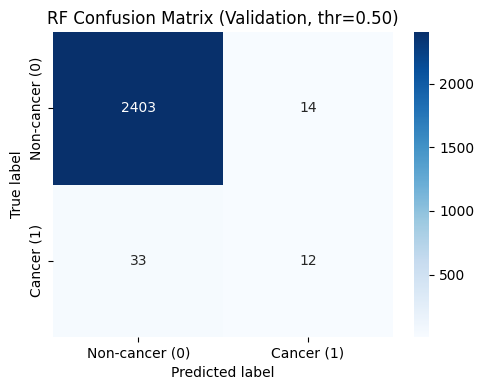

In [6]:
# Predictions (thr = 0.50 by default)
y_val_pred = (y_val_prob >= 0.50).astype(int)

# Metrics table
metrics_rf_val050 = {
    "Set":        ["RF Validation (thr=0.50 default)"],
    "Accuracy":   [accuracy_score(y_val, y_val_pred)],
    "Precision":  [precision_score(y_val, y_val_pred, zero_division=0)],
    "Recall":     [recall_score(y_val, y_val_pred)],
    "F1 Score":   [f1_score(y_val, y_val_pred)],
    "ROC AUC":    [roc_auc_score(y_val, y_val_prob)],
    "PR AUC":     [average_precision_score(y_val, y_val_prob)]
}
df_rf_val050 = pd.DataFrame(metrics_rf_val050)
display(df_rf_val050)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title("RF Confusion Matrix (Validation, thr=0.50)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Threshold tuning by F1

- Sweep candidate thresholds from unique predicted probabilities.  
- Choose the threshold that **maximizes F1** on the validation set.  
- Recompute **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, **PR AUC** at the tuned threshold.  
- Show a confusion matrix at the tuned operating point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,RF Validation (thr=tuned=0.425),0.97766,0.391304,0.4,0.395604,0.859495,0.257404


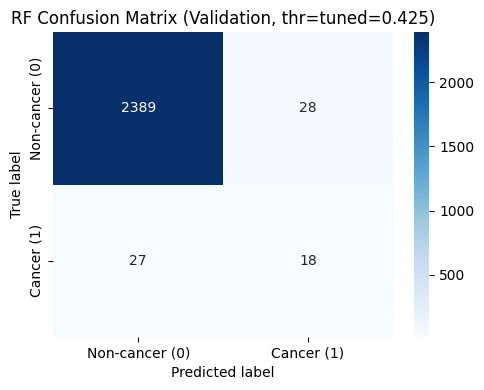

F1-optimal threshold on validation: 0.425163 (Precision=0.391, Recall=0.400, F1=0.396)


In [7]:
# Find F1-optimal threshold from PR curve (
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # thr_v len = len(rec_v) - 1
f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
best_idx = int(np.argmax(f1_v))
tuned_thr = float(thr_v[best_idx])

# Evaluate at tuned threshold
y_val_pred_tuned = (y_val_prob >= tuned_thr).astype(int)

df_rf_val_tuned = pd.DataFrame([{
    "Set":       f"RF Validation (thr=tuned={tuned_thr:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_tuned),
    "Precision": precision_score(y_val, y_val_pred_tuned, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_tuned),
    "F1 Score":  f1_score(y_val, y_val_pred_tuned),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),          # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob) # threshold-free
}])
display(df_rf_val_tuned)

# Confusion Matrix Heatmap (tuned threshold)
cm = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"RF Confusion Matrix (Validation, thr=tuned={tuned_thr:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

print(f"F1-optimal threshold on validation: {tuned_thr:.6f} "
      f"(Precision={prec_v[best_idx]:.3f}, Recall={rec_v[best_idx]:.3f}, F1={f1_v[best_idx]:.3f})")


## Screening scenario (fixed threshold = 0.20)

- Lowering the threshold increases recall at the cost of precision—useful for screening.  
- Evaluate the validation set at `thr = 0.20` and report the same metric table plus a confusion matrix.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,RF Validation (thr=0.20 screening),0.800975,0.066277,0.755556,0.121864,0.859495,0.257404


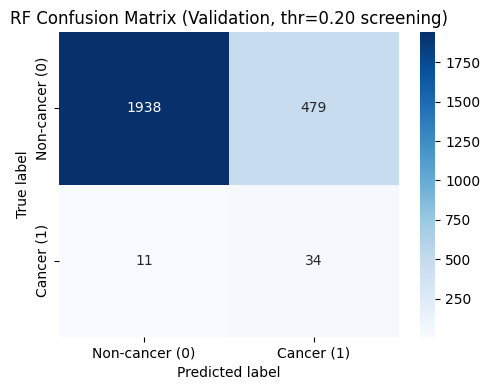

In [8]:
# Evaluate at fixed threshold = 0.20
thr_screen = 0.20
y_val_pred_screen = (y_val_prob >= thr_screen).astype(int)

df_rf_val_screen = pd.DataFrame([{
    "Set":       "RF Validation (thr=0.20 screening)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_screen),
    "Precision": precision_score(y_val, y_val_pred_screen, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_screen),
    "F1 Score":  f1_score(y_val, y_val_pred_screen),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),          # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob) # threshold-free
}])
display(df_rf_val_screen)

# Confusion Matrix Heatmap (screening threshold 0.20)
cm = confusion_matrix(y_val, y_val_pred_screen)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title("RF Confusion Matrix (Validation, thr=0.20 screening)")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Recall-targeted operating point

- Select the **smallest** threshold that achieves a target recall (e.g., `recall ≥ 0.70`), keeping precision as high as possible.  
- If the target is unattainable, fall back to `thr = 0.20`.  
- Report metrics and confusion matrix for this recall-targeted point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"RF Validation (recall≥0.70, thr=0.220)",0.860276,0.088154,0.711111,0.156863,0.859495,0.257404


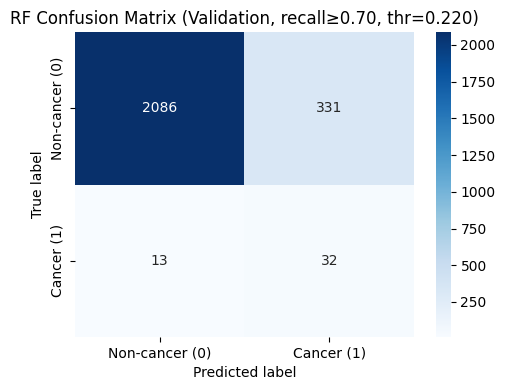

In [9]:
# Choose a recall target
target_recall = 0.70

# Find the largest threshold meeting the recall target
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # thr_v len = len(rec_v) - 1
mask = rec_v[:-1] >= target_recall

if mask.any():
    idx = np.where(mask)[0][-1]          # largest τ that still meets recall
    thr_recall = float(thr_v[idx])
else:
    thr_recall = 0.20                     # fallback if target unattainable

# Evaluate at recall-targeted threshold
y_val_pred_recall = (y_val_prob >= thr_recall).astype(int)

df_rf_val_recall = pd.DataFrame([{
    "Set":       f"RF Validation (recall≥{target_recall:.2f}, thr={thr_recall:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_recall),
    "Precision": precision_score(y_val, y_val_pred_recall, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_recall),
    "F1 Score":  f1_score(y_val, y_val_pred_recall),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),          # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob) # threshold-free
}])
display(df_rf_val_recall)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred_recall)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"RF Confusion Matrix (Validation, recall≥{target_recall:.2f}, thr={thr_recall:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

## Threshold sweep on validation — Methods

- **Procedure:** thresholds from `0.05` to `0.95` in steps of `0.05`.  
  For each `τ`, compute on the validation set:  
  `Precision(τ)`, `Recall(τ)`, and `F1(τ)` using `y_prob` and `ŷ = [p ≥ τ]`.
- **Plot:** three line series (Precision, Recall, F1) with markers.  
  Vertical reference lines mark key operating points:
  - `τ = 0.50` (default)
  - `τ = 0.20` (screening)
  - `τ = tuned_thr` (max-F1)
  - `τ = thr_recall` (recall-targeted)
- **Figure details:** title *“Precision / Recall / F1 vs Threshold • Validation”*,  
  x-axis = **Threshold**, y-axis = **Score**, legend on, grid enabled.

**Figure.** Precision (P), Recall (R), and F1 across thresholds, with dashed lines at chosen operating points.


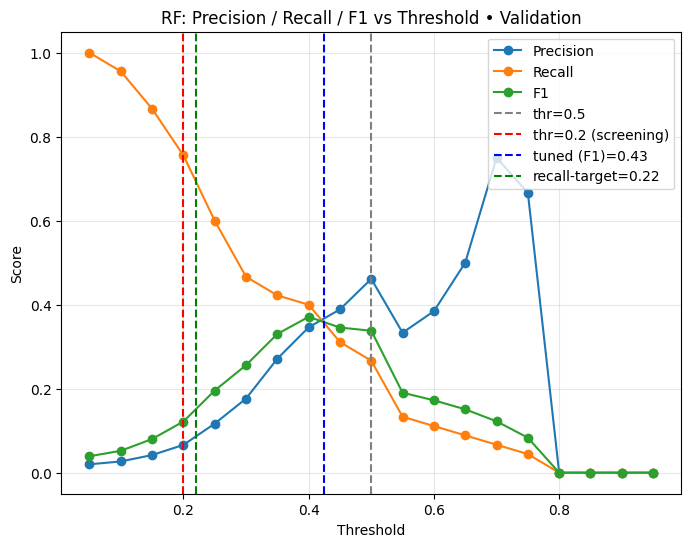

In [10]:
# Threshold sweep for
thresholds = np.arange(0.05, 0.96, 0.05)
precisions, recalls, f1s = [], [], []
for thr in thresholds:
    pred_thr = (y_val_prob >= thr).astype(int)
    precisions.append(precision_score(y_val, pred_thr, zero_division=0))
    recalls.append(recall_score(y_val, pred_thr))
    f1s.append(f1_score(y_val, pred_thr))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls,   marker='o', label='Recall')
plt.plot(thresholds, f1s,       marker='o', label='F1')

# Vertical reference lines
plt.axvline(0.50, color='grey', linestyle='--', label='thr=0.5')
plt.axvline(0.20, color='red',  linestyle='--', label='thr=0.2 (screening)')
plt.axvline(tuned_thr, color='blue', linestyle='--', label=f'tuned (F1)={tuned_thr:.2f}')
plt.axvline(thr_recall, color='green', linestyle='--', label=f'recall-target={thr_recall:.2f}')

plt.title('RF: Precision / Recall / F1 vs Threshold • Validation')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## ROC curve — Validation

- **Computation:** `fpr, tpr = roc_curve(y_val, y_val_prob)` with `auc_val = roc_auc_score(y_val, y_val_prob)`.  
- **Plot:** TPR vs FPR with the diagonal `y = x` as a reference (no-skill).  
- **Reading the figure:** curves further above the diagonal indicate better ranking of positives over negatives; **AUC** summarizes this ranking independent of any threshold.


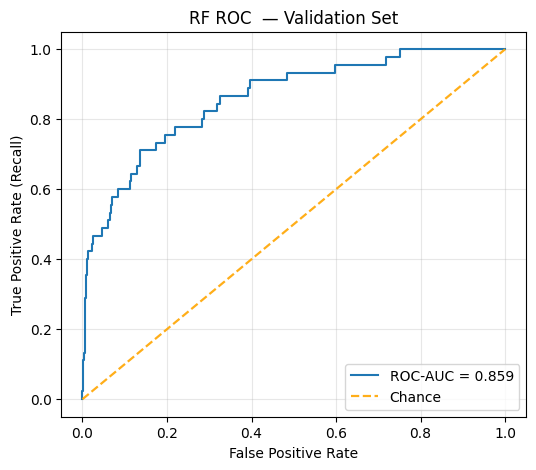

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("RF ROC  — Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Validation

- **Computation:** `prec, rec, _ = precision_recall_curve(y_val, y_val_prob) # Use y_val_prob)` and **Average Precision (AP)** via `average_precision_score(y_val, y_val_prob)`.  
- **Plot:** Precision vs Recall; AP is shown in the legend.  
- **Reading the figure:** with class imbalance, PR curves are more informative than ROC.  
  The **baseline precision** equals the positive prevalence `π = (#positives / #samples)`; curves well above this line indicate useful enrichment.


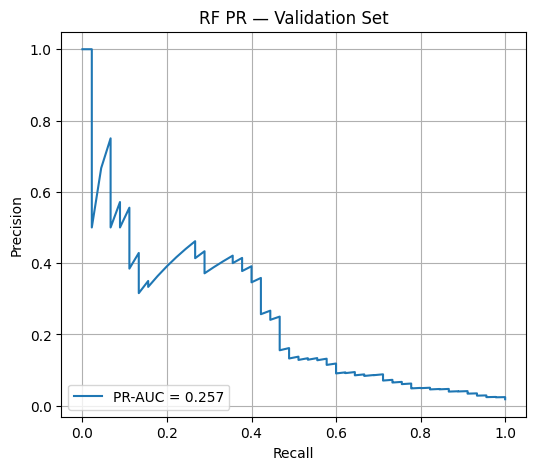

Validation ROC-AUC = 0.859 | PR-AUC = 0.257


In [12]:
# PR Curve
prec, rec, _ = precision_recall_curve(y_val, y_val_prob)
ap = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF PR — Validation Set")
plt.legend(loc="lower left") # Added legend location
plt.grid(True)
plt.show()

print(f"Validation ROC-AUC = {auc_val:.3f} | PR-AUC = {ap:.3f}") # Used ap

## Test-set evaluation

**Goal:** apply the model (fixed from training/validation) to the held-out **test set** and report performance at several operating points.

- **Probabilities:** compute `y_test_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]`.
- **Thresholds evaluated:**
  - `τ = tuned_thr` (chosen on **validation** by max-F1)  
  - `τ = 0.50` (default)  
  - `τ = 0.20` (screening)  
  - `τ = thr_recall` (smallest τ that met the recall target on validation)
- **Leakage control:** thresholds are **carried over from validation**; no re-tuning on test.


RF TEST • Threshold-free
ROC-AUC: 0.837 | PR-AUC: 0.179


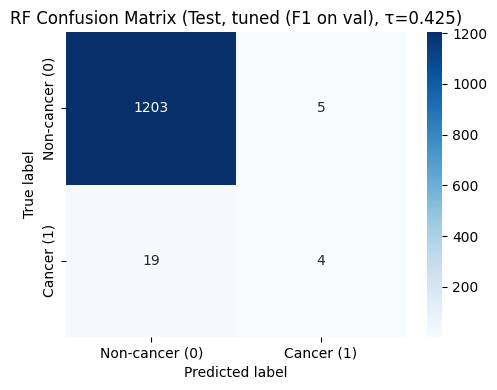

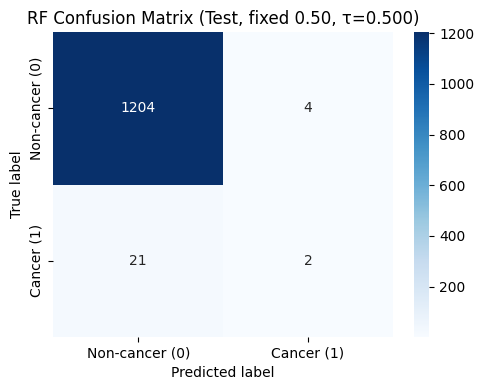

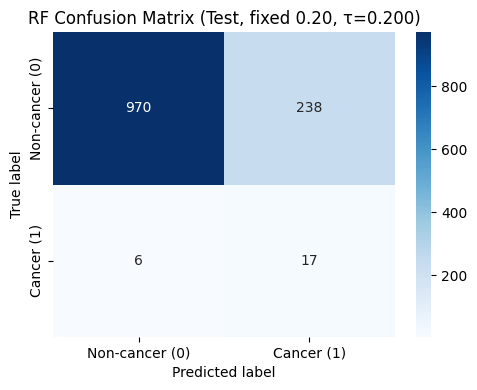

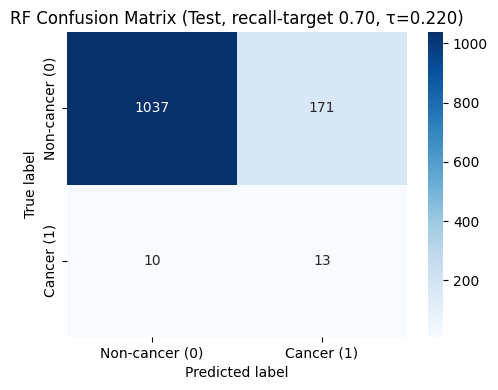

,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"RF Test (tuned (F1 on val), τ=0.425)",0.980504,0.444444,0.173913,0.250000,0.836561,0.178709
1,"RF Test (fixed 0.50, τ=0.500)",0.979691,0.333333,0.086957,0.137931,0.836561,0.178709
2,"RF Test (fixed 0.20, τ=0.200)",0.801787,0.066667,0.739130,0.122302,0.836561,0.178709
3,"RF Test (recall-target 0.70, τ=0.220)",0.852965,0.070652,0.565217,0.125604,0.836561,0.178709


In [13]:
# TEST SET EVALUATION
# Threshold-free metrics
roc_auc_test_rf = roc_auc_score(y_test, y_test_prob)
pr_auc_test_rf  = average_precision_score(y_test, y_test_prob)
print("RF TEST • Threshold-free")
print(f"ROC-AUC: {roc_auc_test_rf:.3f} | PR-AUC: {pr_auc_test_rf:.3f}")

# Helper: evaluate & plot
def evaluate_and_plot_test_rf(y_true, y_prob, thr_value, label):
    y_pred = (y_prob >= thr_value).astype(int)
    row = {
        "Set":       f"RF Test ({label}, τ={thr_value:.3f})",
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred),
        "F1 Score":  f1_score(y_true, y_pred),
        "ROC AUC":   roc_auc_score(y_true, y_prob),           # threshold-free
        "PR AUC":    average_precision_score(y_true, y_prob)  # threshold-free
    }
    df = pd.DataFrame([row])

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Non-cancer (0)", "Cancer (1)"],
        yticklabels=["Non-cancer (0)", "Cancer (1)"]
    )
    plt.title(f"RF Confusion Matrix (Test, {label}, τ={thr_value:.3f})")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()

    return df

# Metrics at each threshold
tables_test_rf = []
tables_test_rf.append(evaluate_and_plot_test_rf(y_test, y_test_prob, tuned_thr, "tuned (F1 on val)"))
tables_test_rf.append(evaluate_and_plot_test_rf(y_test, y_test_prob, 0.50,        "fixed 0.50"))
tables_test_rf.append(evaluate_and_plot_test_rf(y_test, y_test_prob, 0.20,        "fixed 0.20"))
tables_test_rf.append(evaluate_and_plot_test_rf(y_test, y_test_prob, thr_recall, f"recall-target {target_recall:.2f}"))

# Compact combined table for easy comparison
rf_test_summary = pd.concat(tables_test_rf, ignore_index=True)
display(rf_test_summary)

## ROC curve — Test Set

- **Computation:** `fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)` and `auc_val = roc_auc_score(y_test, y_test_prob)`.  
- **Display:** plot TPR vs FPR with the diagonal `y = x` as the no-skill reference.  
- **Interpretation:** the farther the curve bows above the diagonal, the better the ranking of positives over negatives. AUC summarizes this ranking and is **threshold-free**.


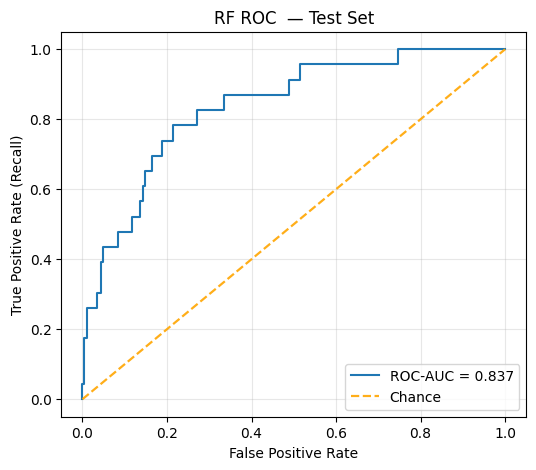

In [14]:
# ROC Curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)
auc_val = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_t, tpr_t, label=f"ROC-AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("RF ROC  — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Test Set

- **Computation:** `prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)` and **Average Precision (AP)** via `average_precision_score(y_test, y_test_prob)`.  
- **Display:** Precision vs Recall with AP shown in the legend.  
- **Interpretation:** PR is more informative than ROC under class imbalance. The implicit baseline equals the positive prevalence; curves well above baseline indicate useful enrichment.


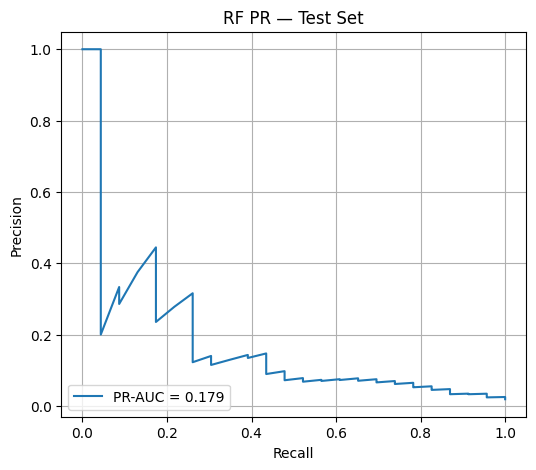

Test ROC-AUC = 0.837 | PR-AUC = 0.179


In [15]:
# PR Curve
prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label=f"PR-AUC = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF PR — Test Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Test ROC-AUC = {auc_val:.3f} | PR-AUC = {ap:.3f}") # Used ap